## Imports

I like to keep my imports organized in a cell at the very top. This avoids multiple imports of the same libraries and makes it easy to find what I've imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

## Intro

The idea of this notebook is to first analyze and understand the dataset used in [this competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). As a second step, I will prepare the dataset for training using common techniques such as **imputing** missing values, **scaling** the data appropriately, and **removing** any unnecessary features. Lastly, I will train a **simple** ML model to predict the pricing of any given apartment/house given several criteria.

The dataset is a modernized and expanded version of the famous Boston Housing dataset, which is why I chose it.

**Disclaimer:** I will use one of my notebooks as inspiration.

# Loading the Data

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA - Getting an Overview

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

It's already clear that we need to remove our target, `SalePrice`, before training. Furthermore, the `Id` column is useless to us, as it merely functions as an offset index; we can drop this one now and handle SalePrice later when defining our X and y.

In [5]:
data.drop(columns = ['Id'], inplace = True)

In [6]:
# Creating a quick view of the NaN percentage per column
nan_counts = data.isna().sum()
total_counts = data.count()

nan_summary = pd.DataFrame({'NaNs': nan_counts, 'Total': total_counts})
nan_summary['NaN Proportion'] = nan_summary['NaNs'] / (nan_summary['NaNs'] + nan_summary['Total'])

contains_nan = nan_summary['NaN Proportion'] > 0
nan_summary[contains_nan].sort_values(by = 'NaN Proportion', ascending = False)

,NaNs,Total,NaN Proportion
PoolQC,1453,7,0.995205
MiscFeature,1406,54,0.963014
Alley,1369,91,0.937671
Fence,1179,281,0.807534
FireplaceQu,690,770,0.472603
LotFrontage,259,1201,0.177397
GarageType,81,1379,0.055479
GarageYrBlt,81,1379,0.055479
GarageFinish,81,1379,0.055479
GarageQual,81,1379,0.055479


Above we can already see that there's a lot of missing data in 5 of the columns. The next step is to analyze whether or not the missing data has meaning. We can look at the data description for this.

> PoolQC: Pool quality -> NA	means No Pool
> 
> Fence: Fence quality -> NA	means No Fence
> 
> MiscFeature: Miscellaneous feature not covered in other categories -> NA	means None
> 
> Alley: Type of alley access to property	 -> NA means 	No alley access
> 
> FireplaceQu: Fireplace quality -> NA	means No Fireplace

From the description above, that missing data has meaning and will most likely influence prices. To avoid any model errors and/or inconsistencies, I will later impute these values.

## Understanding our Features

Now, we need to understand our features. This means that we need to

1. Get a sense of numerical and categorical features
2. Find **all** the features where `NaN` means something (so we can impute properly)
3. Look at how our numerical features are distributed (helps to choose how to scale later)

### Categorical Features

In [7]:
categorical_columns = data.select_dtypes(include = ['object']).columns.tolist()

print(f'Number of features: {len(categorical_columns)}')
categorical_columns

Number of features: 43


['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

#### Imputing

Through a few minutes of manual inspection of the data's description file, we can make a list of features where `NaN` has meaning. These should be imputed.

In [8]:
nan_features = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu',
    'GarageType',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'BsmtFinType2',
    'BsmtExposure',
    'BsmtQual',
    'BsmtCond',
    'BsmtFinType1',
    'MasVnrType'
]

In [9]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
nan_imputer = SimpleImputer(strategy = 'constant', fill_value = 'None')

# Fit the imputer only on relevant columns, then overwrite them
nan_imputer.fit(data[nan_features])
data[nan_features] = nan_imputer.transform(data[nan_features])

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


Aside from those features, there is only one categorical feature left with `NaN`s: `Electrical`

In [11]:
leftover_nans = data[categorical_columns].isna().sum().to_frame()

leftover_nans[leftover_nans[0] > 0]

,0
Electrical,1


#### Encoding

The other thing we need to do is encode our features. We have two kinds: categorical and ordinal features.

Sadly, we need to ordinally encode manually by creating a mapping dictionary and then replacing the values in the DF. I realize I could use an OrdinalEncoder from Sklearn here, but then I would have to watch the order of the categories much more closely, it's more prone to errors.

In [12]:
ordinal_mappings = {
    'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3},
    'LandContour': {'Low': 0, 'Bnk': 1, 'HLS': 2, 'Lvl': 3},
    'Utilities': {'NoSeWa': 0, 'AllPub': 1},
    'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
    'ExterQual': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtQual': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4},
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4},
    'KitchenQual': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
    'Functional': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
}

In [13]:
data[ordinal_mappings.keys()].head()

,LotShape,LandContour,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,Reg,Lvl,AllPub,Gtl,Gd,TA,Gd,TA,No,GLQ,...,SBrkr,Gd,Typ,None,RFn,TA,TA,Y,None,None
1,Reg,Lvl,AllPub,Gtl,TA,TA,Gd,TA,Gd,ALQ,...,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,None,None
2,IR1,Lvl,AllPub,Gtl,Gd,TA,Gd,TA,Mn,GLQ,...,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,None,None
3,IR1,Lvl,AllPub,Gtl,TA,TA,TA,Gd,No,ALQ,...,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,None,None
4,IR1,Lvl,AllPub,Gtl,Gd,TA,Gd,TA,Av,GLQ,...,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,None,None


In [14]:
data.replace(ordinal_mappings, inplace=True)

In [15]:
data[ordinal_mappings.keys()].head()

,LotShape,LandContour,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,3,3,1,2,2,2,3,3,1,6,...,4.0,2,6,0,2,3,3,2,0,0
1,3,3,1,2,1,2,3,3,4,5,...,4.0,1,6,3,2,3,3,2,0,0
2,2,3,1,2,2,2,3,3,2,6,...,4.0,2,6,3,2,3,3,2,0,0
3,2,3,1,2,1,2,2,4,1,5,...,4.0,2,6,4,1,3,3,2,0,0
4,2,3,1,2,2,2,3,3,3,6,...,4.0,2,6,3,2,3,3,2,0,0


The rest we can OHE.

In [16]:
data.drop(ordinal_mappings.keys())

KeyError: "['LotShape' 'LandContour' 'Utilities' 'LandSlope' 'ExterQual' 'ExterCond'\n 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'\n 'HeatingQC' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'\n 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence'] not found in axis"

### Numerical Features

Since we're going to start manipulating numerical data, it would be wise to remove `SalePrice` before moving on.

In [12]:
data.drop(columns = ['SalePrice'], inplace = True)

In [13]:
numerical_columns = data.select_dtypes(include = ['int', 'float']).columns.tolist()

print(f'Number of features: {len(numerical_columns)}')
numerical_columns

Number of features: 36


['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Now we need to understand how our numbers are distributed to understand how best to scale the data.

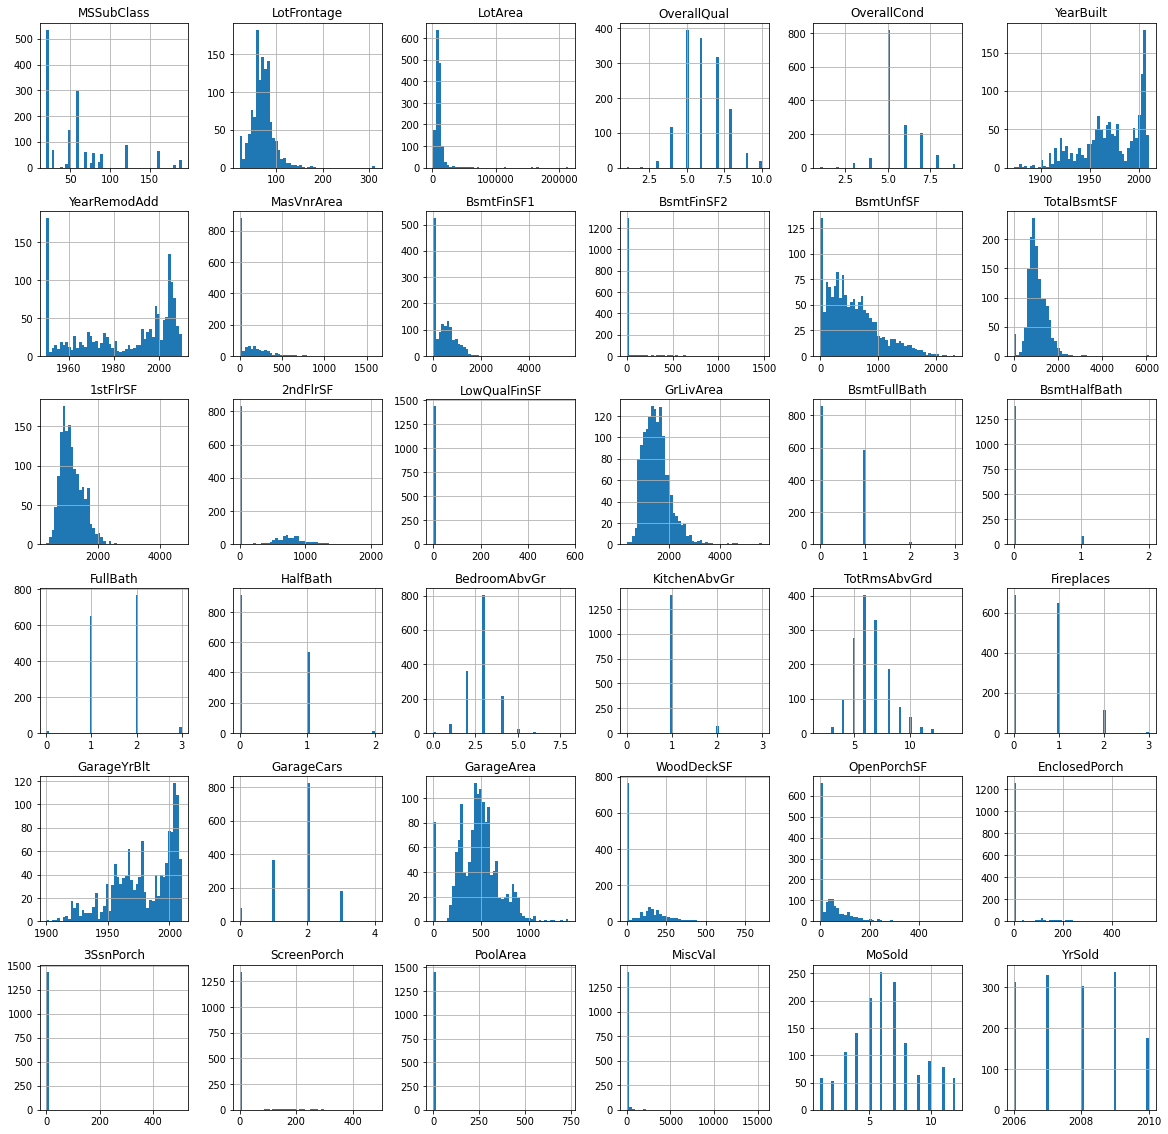

In [14]:
data[numerical_columns].hist(figsize = (20, 20), bins = 50);

It looks like a RobustScaler might be a safer option. With a bigger time investment, however, there's surely room for improvement here, although I would rather try tuning models before trying different scalers.

In [15]:
scaler = RobustScaler()

scaler.fit(data[numerical_columns])
data[numerical_columns] = scaler.transform(data[numerical_columns])

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.2,RL,-0.190476,-0.254076,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,-1.333333,0.0,WD,Normal
1,-0.6,RL,0.523810,0.030015,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,-0.333333,-0.5,WD,Normal
2,0.2,RL,-0.047619,0.437624,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,1.000000,0.0,WD,Normal
3,0.4,RL,-0.428571,0.017663,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,0.0,None,None,None,0.0,-1.333333,-1.0,WD,Abnorml
4,0.2,RL,0.714286,1.181201,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,2.000000,0.0,WD,Normal
